In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim



from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/catndog.zip 파일 선택

Saving covid19.zip to covid19.zip


In [ ]:
!unzip covid19.zip -d covid/

Archive:  covid19.zip
   creating: covid/covid19/covid19/
   creating: covid/covid19/covid19/Covid19-dataset/
   creating: covid/covid19/covid19/Covid19-dataset/test/
   creating: covid/covid19/covid19/Covid19-dataset/test/Covid/
  inflating: covid/covid19/covid19/Covid19-dataset/test/Covid/[┼й▒т║п╚п]0100.jpeg  
  inflating: covid/covid19/covid19/Covid19-dataset/test/Covid/[┼й▒т║п╚п]0102.jpeg  
  inflating: covid/covid19/covid19/Covid19-dataset/test/Covid/[┼й▒т║п╚п]0105.png  
  inflating: covid/covid19/covid19/Covid19-dataset/test/Covid/[┼й▒т║п╚п]0106.jpeg  
  inflating: covid/covid19/covid19/Covid19-dataset/test/Covid/[┼й▒т║п╚п]0108.jpeg  
  inflating: covid/covid19/covid19/Covid19-dataset/test/Covid/[┼й▒т║п╚п]0111.jpg  
  inflating: covid/covid19/covid19/Covid19-dataset/test/Covid/[┼й▒т║п╚п]0112.jpg  
  inflating: covid/covid19/covid19/Covid19-dataset/test/Covid/[┼й▒т║п╚п]0113.jpg  
  inflating: covid/covid19/covid19/Covid19-dataset/test/Covid/[┼й▒т║п╚п]0115.jpeg  
  inflating: covid

In [ ]:
data_path = 'covid/covid19/covid19/Covid19-dataset/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=60,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

259


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
test_path = 'covid/covid19/covid19/Covid19-dataset/test/'
transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=60,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

86


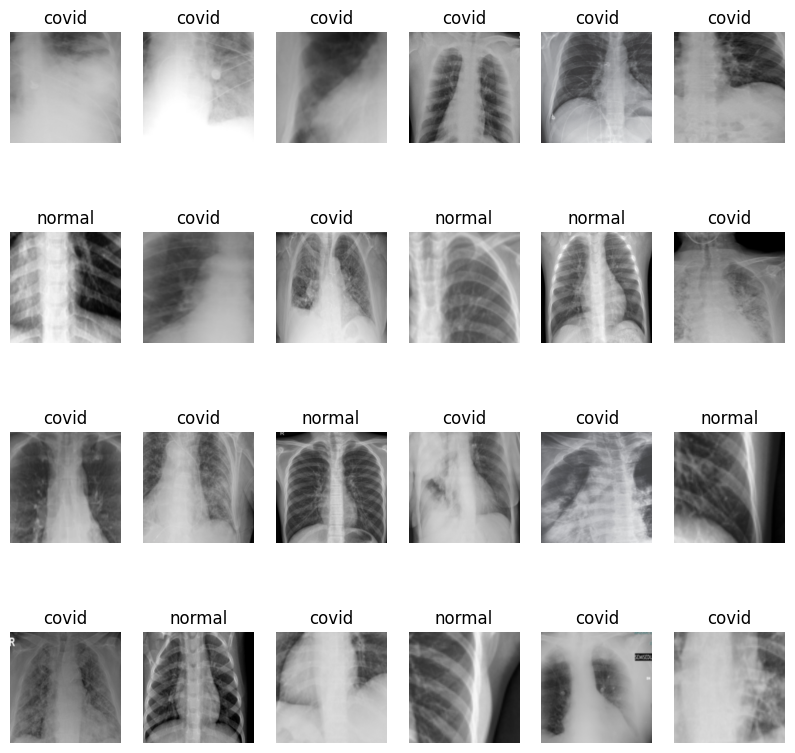

In [ ]:
samples, labels = next(iter(train_loader))
classes = {0 : 'covid',1 : 'normal' }
fig = plt.figure(figsize=(10,20))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [ ]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=193600, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.001;
model = FashionCNN();
model.to(device)


criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=193600, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=2, bias=True)
)


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=20, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('covid/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [ ]:
train_acc_hist, train_loss_hist = train_model(model, train_loader, criterion, optimizer, device)

Epoch 0/19
----------


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Loss: 80.3124 Acc: 0.5019

Epoch 1/19
----------
Loss: 28.1084 Acc: 0.5985

Epoch 2/19
----------
Loss: 22.6986 Acc: 0.7490

Epoch 3/19
----------
Loss: 13.6605 Acc: 0.7066

Epoch 4/19
----------
Loss: 7.4636 Acc: 0.6950

Epoch 5/19
----------
Loss: 5.2519 Acc: 0.7606

Epoch 6/19
----------
Loss: 3.6278 Acc: 0.7027

Epoch 7/19
----------
Loss: 3.0181 Acc: 0.7722

Epoch 8/19
----------
Loss: 2.5192 Acc: 0.7992

Epoch 9/19
----------
Loss: 1.7755 Acc: 0.8147

Epoch 10/19
----------
Loss: 1.5419 Acc: 0.8069

Epoch 11/19
----------
Loss: 1.5283 Acc: 0.8185

Epoch 12/19
----------
Loss: 0.6218 Acc: 0.8340

Epoch 13/19
----------
Loss: 0.6479 Acc: 0.7876

Epoch 14/19
----------
Loss: 0.7716 Acc: 0.8533

Epoch 15/19
----------
Loss: 0.5164 Acc: 0.8456

Epoch 16/19
----------
Loss: 0.5441 Acc: 0.8147

Epoch 17/19
----------
Loss: 0.3851 Acc: 0.8571

Epoch 18/19
----------
Loss: 0.5114 Acc: 0.8880

Epoch 19/19
----------
Loss: 0.4293 Acc: 0.8494

Training complete in 3m 17s
Best Acc: 0.888031


In [ ]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('covid/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history



In [ ]:
val_acc_hist = eval_model(model, test_loader, device)

saved_model ['covid/00.pth', 'covid/01.pth', 'covid/02.pth', 'covid/03.pth', 'covid/04.pth', 'covid/05.pth', 'covid/06.pth', 'covid/07.pth', 'covid/08.pth', 'covid/09.pth', 'covid/10.pth', 'covid/11.pth', 'covid/12.pth', 'covid/13.pth', 'covid/14.pth', 'covid/15.pth', 'covid/16.pth', 'covid/17.pth', 'covid/18.pth', 'covid/19.pth']
Loading model covid/00.pth
Acc: 0.5349

Loading model covid/01.pth
Acc: 0.5349

Loading model covid/02.pth
Acc: 0.7093

Loading model covid/03.pth
Acc: 0.5349

Loading model covid/04.pth
Acc: 0.7791

Loading model covid/05.pth
Acc: 0.6047

Loading model covid/06.pth
Acc: 0.5581

Loading model covid/07.pth
Acc: 0.7209

Loading model covid/08.pth
Acc: 0.6977

Loading model covid/09.pth
Acc: 0.5814

Loading model covid/10.pth
Acc: 0.8256

Loading model covid/11.pth
Acc: 0.7907

Loading model covid/12.pth
Acc: 0.6512

Loading model covid/13.pth
Acc: 0.8488

Loading model covid/14.pth
Acc: 0.8721

Loading model covid/15.pth
Acc: 0.8023

Loading model covid/16.pth


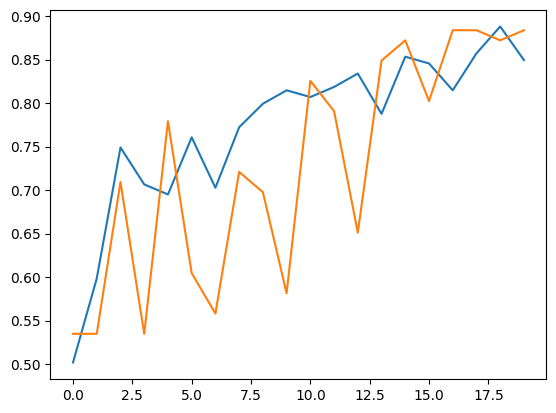

In [ ]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

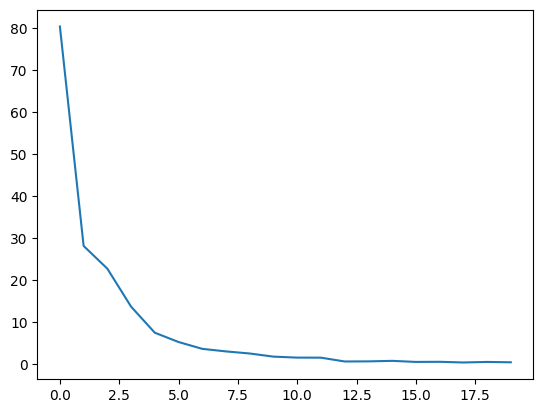

In [ ]:
plt.plot(train_loss_hist)
plt.show()

In [ ]:
def im_convert(tensor):
    image=tensor.clone().detach().numpy()
    image=image.transpose(1,2,0)
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
    image=image.clip(0,1)
    return image

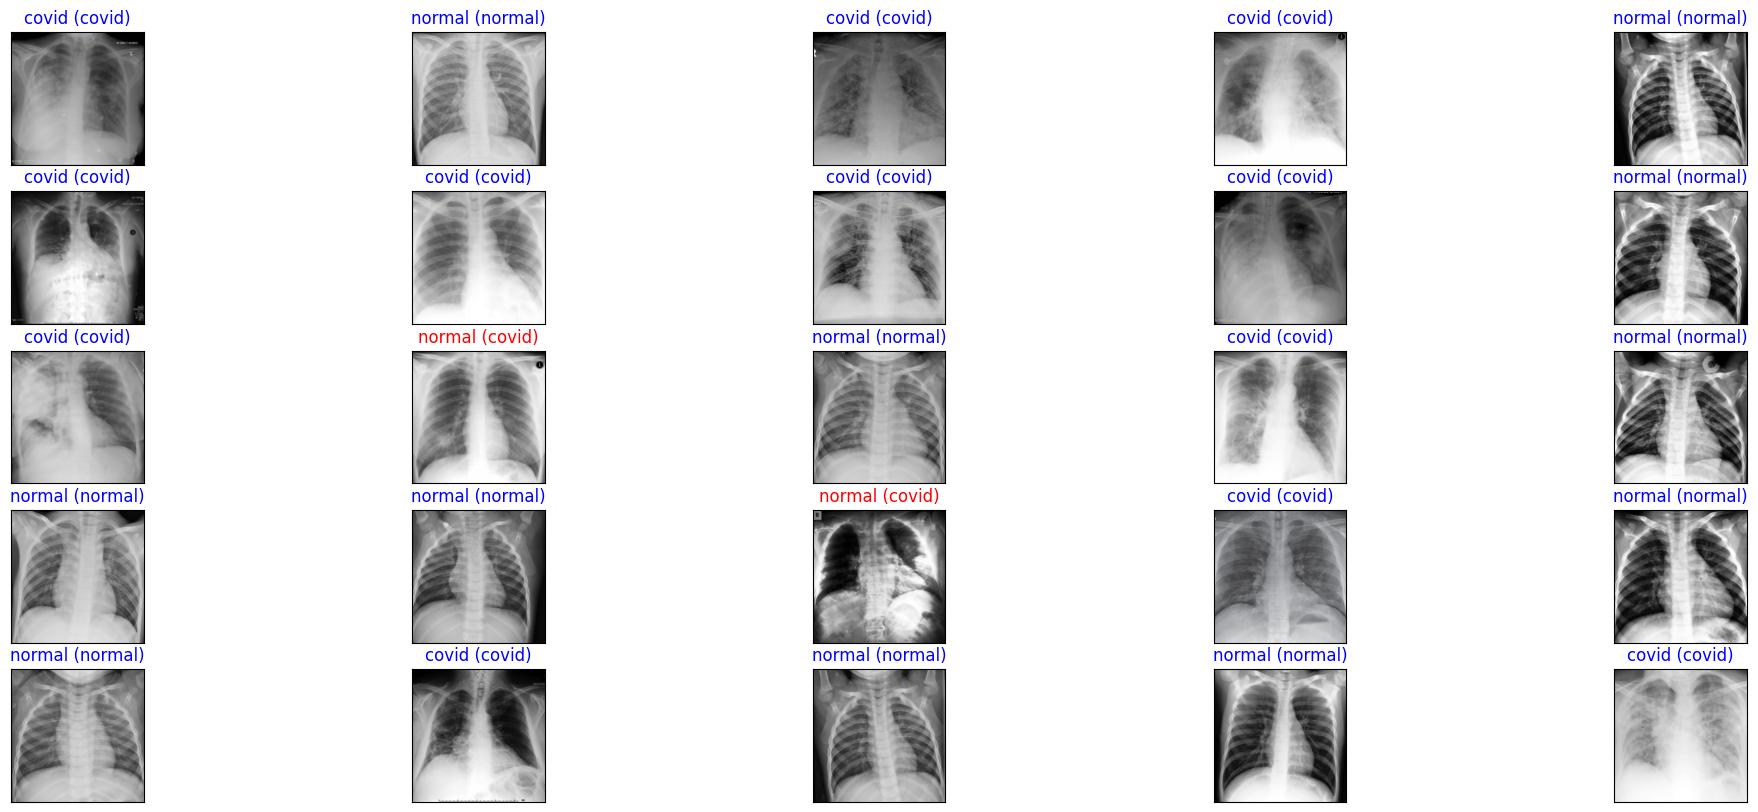

<Figure size 640x480 with 0 Axes>

In [ ]:
classes = {0: 'covid', 1: 'normal'}

images, labels = next(iter(test_loader))
images = images.to(device)  # 입력 텐서를 GPU로 이동

output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 10))
for idx in np.arange(25):
    ax = fig.add_subplot(5, 5, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx].cpu()))  # CUDA 디바이스의 텐서를 호스트 메모리로 복사한 후에 NumPy 배열로 변환

    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
                 color=("blue" if preds[idx] == labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)


In [ ]:
actual = []
deep_features = []

model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = model(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

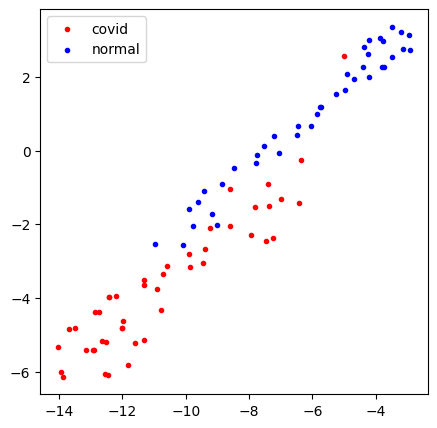

In [ ]:
plt.figure(figsize=(5, 5))
name = ['covid','normal']
color = ['red','blue']
for i, label,color in zip(range(2), name, color):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label,color = color)
plt.legend()
plt.show()